# Activations, Gradients, BatchNorm

In [1]:
# Imports
import torch
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Hyperparaeters
block_size = 5          # Context Length! How many characters to take to predict the next one
embid_size = 15          # How many dimension in the embedding space
batch_size = 256
num_hidden = 256        # Number of neurons in the hidden layer
lr = 0.05
epochs = 50000

In [4]:
# Dataset

DATA_DIR = "../data/indian_names.txt"

train_split = 0.8
dev_split = 0.1
test_split = 0.1

assert (train_split + dev_split + test_split) == 1.0, "Data Split ration does not add up to 1.0"

# Loading data
words = open(DATA_DIR, 'r').read().splitlines()
print(len(words), "words.")

# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']
chrs = sorted(chrs + special_characters)

# Takes some words and builds X and Y data out of it
def build_dataset(words, type = 'train'):
    
    X, Y = [], []

    for word in words:
        #print(''.join(word))
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Shape of {type} data is     X -> {X.shape}      Y ->  {Y.shape}")

    return X, Y

# Shuffling the data
random.seed(800)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Calling build
Xtrain, Ytrain = build_dataset(words[:n1], "train")
Xdev, Ydev = build_dataset(words[n1:n2], "dev")
Xtest, Ytest = build_dataset(words[n2:], "test")

6474 words.
Shape of train data is     X -> torch.Size([38221, 5])      Y ->  torch.Size([38221])
Shape of dev data is     X -> torch.Size([4691, 5])      Y ->  torch.Size([4691])
Shape of test data is     X -> torch.Size([4705, 5])      Y ->  torch.Size([4705])


In [32]:
# Weights initializing
g = torch.Generator().manual_seed(800)

C = torch.randn((len(chrs), embid_size), generator=g)

w1 = torch.randn((block_size*embid_size, num_hidden), generator=g)
b1 = torch.randn((num_hidden), generator=g)

w2 = torch.randn((num_hidden, len(chrs)), generator=g) * 0
b2 = torch.randn(len(chrs), generator=g) * 0

parameters = [C, w1, b1, w2, b2]

In [33]:
# Checking parameters
for p in parameters:
    p.requires_grad = True
print("Total parameters to train -->", sum(p.nelement() for p in parameters))

Total parameters to train --> 26800


In [34]:
# Accumulation storage
loss_track = []
lr_track = []

lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [35]:
# Training Loop

for epoch in range(epochs):

    # Batch creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))

    # Forward Pass
    emb = C[Xtrain[ix]]      # Shape [batch_dim, block_dim, emb_dim]
    h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
    logits = h @ w2 + b2            # Shape [batch_size, vocab]
    loss = F.cross_entropy(logits, Ytrain[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[epoch]
    lr = 0.005
    for p in parameters:
        p.data -= lr * p.grad

    # Statistics
    if epoch % 10000 == 0:
        print(f'{epoch=} and {loss.item()=}')

    # Accumulate
    loss_track.append(loss.log10().item())
    lr_track.append(lr)

epoch=0 and loss.item()=3.295837163925171
epoch=10000 and loss.item()=2.1104607582092285
epoch=20000 and loss.item()=1.9180697202682495
epoch=30000 and loss.item()=1.9745254516601562
epoch=40000 and loss.item()=2.0392088890075684


In [31]:
# Testing loss on a dataset
@torch.no_grad()
def split_loss(split):
    xs, ys = {
        'train' : (Xtrain, Ytrain),
        'dev' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]

    # Forward Pass
    emb = C[xs]      # Shape [batch_dim, block_dim, emb_dim]
    h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
    logits = h @ w2 + b2            # Shape [batch_size, vocab]
    loss = F.cross_entropy(logits, ys)

    print(f"{split} loss        ->      {loss.item()}")

split_loss('train')
split_loss('dev')

train loss        ->      2.039954423904419
dev loss        ->      2.1359634399414062


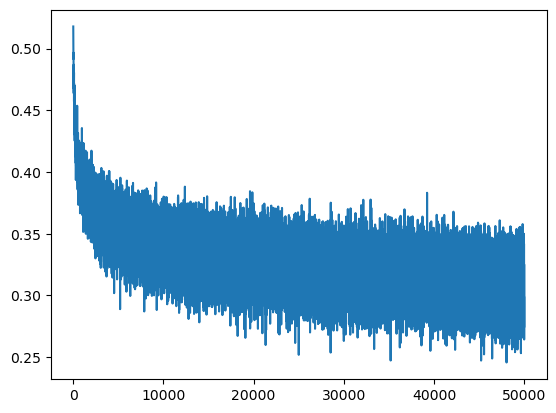

In [30]:
# Plotting the loss vs epochs
plt.plot(range(len(loss_track)), loss_track)

In [18]:
# Sample from the model
g = torch.Generator().manual_seed(700)

num_names = 20
names = []

for i in range(num_names):

    name = ""
    context = [0] * block_size

    while True:
        # forward pass
        emb = C[torch.tensor([context])]        # [1, block_size, emb_size]
        h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
        logits = h @ w2 + b2            # Shape [batch_size, vocab]
        probs = F.softmax(logits, dim = 1)
        # sample from this dist
        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator=g).item()
        context = context[1:] + [ix]
        # break and save because end of word
        if itos[ix] == '.':
            names.append(name)
            break
        # store characters
        name = name + itos[ix]

names

['manrbh',
 'mubid',
 'mutya',
 'saiyapri',
 'jatto',
 'alqulelkas',
 'buded',
 'saudum',
 'sahwendesh',
 'khnob',
 'shana',
 'naxma',
 'samon',
 'betni',
 'turtoot',
 'yogh',
 'tanvika',
 'bhiru',
 'chald',
 'rohnmashni']

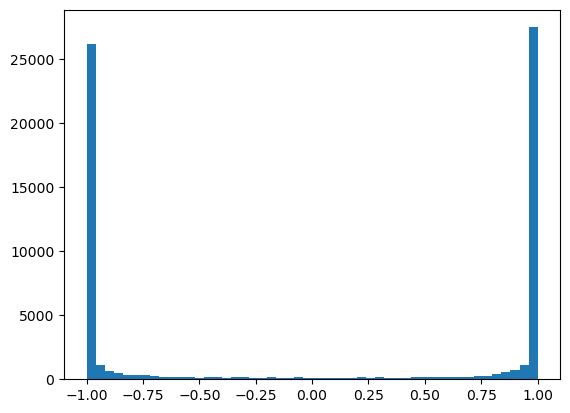

In [37]:
# Figuring out tanh
plt.hist(h.view(-1).tolist(), 50);

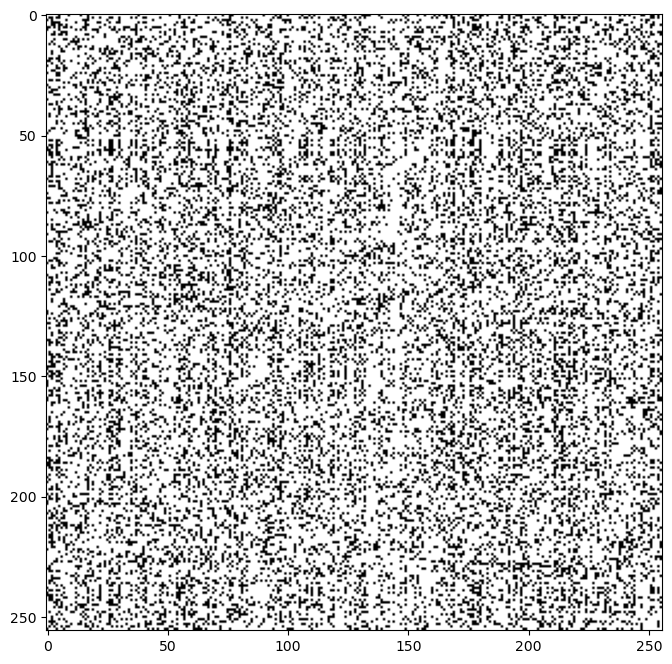

In [45]:
plt.figure(figsize = (8,8))
plt.imshow(h.abs() > 0.99, cmap = 'gray');